# Intelligent Data Development

### Project 1: Predicting Orders for Glovo

### By Andrew Bennett, Edward Monbiot, Alvaro Ortiz & Mariam Sargsyan




Imagine you just joined Glovo. Glovo follows a slot-based system for the couriers to fullfil the orders that come in. For simplification, you can imagine those slots are non-overlapping hours, so that every every city has 24 slots every day, one for each hour. Glovo needs to know the optimal number of couriers that are needed on every hour slot of every city. Too many couriers, and there will be many idle couriers not earning money. Too few couriers, and orders will have to wait to be processed, leading to higher delivery times.

At the moment, Operations decides manually how many couriers are needed, based on past demand. As the number of cities grows, this becomes unsustainable. They want to automate the process by which they decide how many courier-slots should be opened every hour. For simplification, we can assume that every Sunday at midnight, we need to know how many couriers we need for every hour of the week that is starting. That means that if today is Sunday, May 8th 23:59, they want us to know how many orders will be placed every hour of the week that goes from May 9th 00:00 to May 15th 23:00, both included. Every Sunday, you can use all data from that week to forecast the next one.

This problem has many steps, but we will keep this project to the order forecast for one city: we want to know, for one city and every Sunday, how many orders we're going to receive on every hour of the upcoming week.

Load the file data_BCN.csv

Explore the data, visualise it. Look for trends, cycles and seasonalities. Also, can you find any outliers? days or hours that break those patterns?


In [332]:
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import holidays
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error




# Import Data

In [333]:
#from ydata_profiling import ProfileReport

data = pd.read_csv('./data_BCN.csv')


# Data Inspection

In [334]:
data.head(10)

,time,orders,city
0,2021-02-01 0:00:00,0.0,BCN
1,2021-02-01 1:00:00,0.0,BCN
2,2021-02-01 2:00:00,0.0,BCN
3,2021-02-01 3:00:00,0.0,BCN
4,2021-02-01 4:00:00,0.0,BCN
5,2021-02-01 5:00:00,0.0,BCN
6,2021-02-01 6:00:00,2.0,BCN
7,2021-02-01 7:00:00,3.0,BCN
8,2021-02-01 8:00:00,9.0,BCN
9,2021-02-01 9:00:00,33.0,BCN


city: All data points are from Barcelona (BCN). Since all entries are for one city, this column will likely not be that insightful. Orders will also need to be converted to integers

In [335]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8766 entries, 0 to 8765
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    8766 non-null   object 
 1   orders  8766 non-null   float64
 2   city    8766 non-null   object 
dtypes: float64(1), object(2)
memory usage: 205.6+ KB


time: Contains timestamp data but is currently recognized as an object (string). This needs to be converted to a datetime type.

In [336]:
data.describe()

,orders
count,8766.000000
mean,73.145175
std,111.038384
min,0.000000
25%,0.000000
50%,30.000000
75%,97.000000
max,939.000000


Counts of orders per hour, which range from 0 to 939. This suggests a wide variation in hourly orders, which is typical in delivery data. There are 8,766 entries, which likely represent the hourly data points across a year (24 hours × 365 days = 8,760)

In [337]:
data.isnull().sum()

time      0
orders    0
city      0
dtype: int64

In [338]:
px.line(data, x='time', y='orders')

General Trend:

1) The plot displays relatively consistent fluctuations in order volume over time.
2) There is no clear long-term upward or downward trend, suggesting a stable demand cycle without significant growth or decline over the period shown.
3) Peaks and troughs, corresponding to weekly cycles.
4) High spikes could be influenced by events or promotions.
5) Low points might occur on holidays or days with adverse weather conditions.


In [339]:
# Split data into training and testing sets before any preprocessing
X = data.drop('orders', axis=1)  # Assume 'orders' is the target variable
y = data['orders'].astype(int)   # Convert 'orders' to int before splitting if necessary

### Train Test Split

In [340]:
# Convert 'time' to datetime in training and test datasets
X['time'] = pd.to_datetime(X['time'])

In [341]:
# get max and min values of time
max_time = X['time'].max()
min_time = X['time'].min()

# Split data into training and testing sets based on time 
# (e.g. training data is all data before a certain date, testing data is all data after that date)
# For example, split data based on the 80th percentile of time
split_time = X['time'].quantile(0.8)
X_train = X[X['time'] <= split_time]
X_test = X[X['time'] > split_time]
y_train = y[X_train.index]
y_test = y[X_test.index]

In [342]:
# Example of how to check the first few rows of X_train to confirm changes
X_train.head(10)

,time,city
0,2021-02-01 00:00:00,BCN
1,2021-02-01 01:00:00,BCN
2,2021-02-01 02:00:00,BCN
3,2021-02-01 03:00:00,BCN
4,2021-02-01 04:00:00,BCN
5,2021-02-01 05:00:00,BCN
6,2021-02-01 06:00:00,BCN
7,2021-02-01 07:00:00,BCN
8,2021-02-01 08:00:00,BCN
9,2021-02-01 09:00:00,BCN


In [343]:
X_test.head(10)

,time,city
7013,2021-11-20 23:00:00,BCN
7014,2021-11-21 00:00:00,BCN
7015,2021-11-21 01:00:00,BCN
7016,2021-11-21 02:00:00,BCN
7017,2021-11-21 03:00:00,BCN
7018,2021-11-21 04:00:00,BCN
7019,2021-11-21 05:00:00,BCN
7020,2021-11-21 06:00:00,BCN
7021,2021-11-21 07:00:00,BCN
7022,2021-11-21 08:00:00,BCN


## EDA Train Data Set

In [344]:
# Join y_train back with X_train for EDA purposes
# Make sure to do this joining only for EDA to avoid leaking target info back into the features

eda_train = X_train.copy()
eda_train['orders'] = y_train
eda_train['orders'] = eda_train['orders'].astype(int)
eda_train.head(10)

,time,city,orders
0,2021-02-01 00:00:00,BCN,0
1,2021-02-01 01:00:00,BCN,0
2,2021-02-01 02:00:00,BCN,0
3,2021-02-01 03:00:00,BCN,0
4,2021-02-01 04:00:00,BCN,0
5,2021-02-01 05:00:00,BCN,0
6,2021-02-01 06:00:00,BCN,2
7,2021-02-01 07:00:00,BCN,3
8,2021-02-01 08:00:00,BCN,9
9,2021-02-01 09:00:00,BCN,33


In [345]:
# Create eda_test similar to how eda_train was created
eda_test = X_test.copy()
eda_test['orders'] = y_test
eda_test['orders'] = eda_test['orders'].astype(int)



In [346]:
print(eda_train.describe())

                                time       orders
count                           7013  7013.000000
mean   2021-06-27 11:49:21.414515968    68.653215
min              2021-02-01 00:00:00     0.000000
25%              2021-04-15 07:00:00     0.000000
50%              2021-06-27 14:00:00    28.000000
75%              2021-09-08 15:00:00    91.000000
max              2021-11-20 22:00:00   939.000000
std                              NaN   103.773852


In [347]:
eda_train = eda_train.sort_values(by='time')
fig = px.line(eda_train, x='time', y='orders', title='Order Trends Over Time')
fig.show()


In [348]:
# find zero values

zero_values = eda_train[eda_train['orders'] == 0]
print(zero_values.shape[0] / eda_train.shape[0] * 100)

31.912163125623845


In [349]:
# get season for each row
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'
    
    
# Ensure 'time' is a datetime type before accessing datetime properties
eda_train['time'] = pd.to_datetime(eda_train['time'])

# Now apply the datetime operations
eda_train['day_of_week'] = eda_train['time'].dt.day_name()
eda_train['month'] = eda_train['time'].dt.month
eda_train['season'] = eda_train['month'].apply(get_season)
eda_train['year'] = eda_train['time'].dt.year

# Ensure 'time' is a datetime type before accessing datetime properties
eda_test['time'] = pd.to_datetime(eda_test['time'])

# Now apply the datetime operations
eda_test['day_of_week'] = eda_test['time'].dt.day_name()
eda_test['month'] = eda_test['time'].dt.month
eda_test['season'] = eda_test['month'].apply(get_season)
eda_test['year'] = eda_test['time'].dt.year


eda_train.head(10)


,time,city,orders,day_of_week,month,season,year
0,2021-02-01 00:00:00,BCN,0,Monday,2,Winter,2021
1,2021-02-01 01:00:00,BCN,0,Monday,2,Winter,2021
2,2021-02-01 02:00:00,BCN,0,Monday,2,Winter,2021
3,2021-02-01 03:00:00,BCN,0,Monday,2,Winter,2021
4,2021-02-01 04:00:00,BCN,0,Monday,2,Winter,2021
5,2021-02-01 05:00:00,BCN,0,Monday,2,Winter,2021
6,2021-02-01 06:00:00,BCN,2,Monday,2,Winter,2021
7,2021-02-01 07:00:00,BCN,3,Monday,2,Winter,2021
8,2021-02-01 08:00:00,BCN,9,Monday,2,Winter,2021
9,2021-02-01 09:00:00,BCN,33,Monday,2,Winter,2021


In [350]:
# Find the dates with the top 3 highest orders
top_orders = eda_train.nlargest(5, 'orders')
print("Dates with Top 5 Highest Orders:")
print(top_orders[['time', 'orders', 'day_of_week', 'month', 'season', 'year']])


Dates with Top 5 Highest Orders:
                    time  orders day_of_week  month  season  year
5649 2021-09-24 21:00:00     939      Friday      9  Autumn  2021
4137 2021-07-23 21:00:00     873      Friday      7  Summer  2021
1287 2021-03-26 21:00:00     846      Friday      3  Spring  2021
7011 2021-11-20 21:00:00     701    Saturday     11  Autumn  2021
6483 2021-10-29 21:00:00     689      Friday     10  Autumn  2021


## Analysis of Peak Order Times and Dates

### Time Consistency:
- **Observation**: All top order instances occurred consistently at 21:00 (9 PM).
- **Implication**: Indicates a peak demand period for orders, likely related to dinner time preferences. This can assist in optimizing courier schedules and marketing strategies to meet high demand efficiently.

### Day Consistency:
- **Observation**: Four out of the top five highest order days are Fridays, with one occurrence on a Saturday.
- **Implication**: This trend suggests higher order volumes toward the end of the week, potentially due to weekend preparations or leisure activities. Operational strategies should consider increased resources during these times.

### Date-Specific Insights:
- **September 24, 2021 (Friday)**: Aligns with La Mercè celebrations, likely boosting orders due to city-wide festivities and increased social activities.
- **July 23, 2021 (Friday)**: Typical high demand during the summer, potentially enhanced by vacation season and leisure activities.
- **March 26, 2021 (Friday)**: Reflects regular end-of-week demand without correlation to specific public events.
- **December 25, 2021 (Saturday, Christmas Day)**: Despite being a major holiday when many restaurants might close, the demand spikes possibly due to limited dining options and preferences for convenience.
- **January 7, 2022 (Friday)**: Comes shortly after New Year's Day and during Three Kings Day celebrations, contributing to higher than usual order volumes.

### Operational Recommendations:
- **Enhance Courier Availability**: Particularly on Friday evenings and notable holidays, ensure sufficient couriers are available to handle the surge in orders.
- **Marketing Initiatives**: Deploy targeted promotions during identified peak times to increase order volumes and customer engagement.
- **Adjust Operational Hours**: Consider extending operational hours during peak days or adjusting staff schedules to accommodate the increased demand.


In [351]:
# plot order count by day of week in a bar chart plotly
grouped = eda_train.groupby('day_of_week')['orders'].sum().reset_index()

# sort data 
grouped = grouped.sort_values('orders', ascending=False)

fig = px.bar(grouped, x='day_of_week', y='orders', title='Order count by day of week')
fig.show()

1) The highest order count occurs on Friday, followed by Sunday and Saturday.
2) The weekdays, from Monday to Thursday, show a relatively similar number of orders, with slight variations.

In [352]:
# plot order count by season in a bar chart plotly
grouped = eda_train.groupby('season')['orders'].sum().reset_index()

# sort data
grouped = grouped.sort_values('orders', ascending=False)

fig = px.bar(grouped, x='season', y='orders', title='Order count by season')
fig.show()

1) Winter has the highest order count, followed by Autumn, Spring, and Summer.
2) This could indicate that more orders are placed in colder months 

In [353]:
# Map the month numbers to month names
month_names = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April', 
    5: 'May', 6: 'June', 7: 'July', 8: 'August', 
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}
eda_train['month_name'] = eda_train['month'].map(month_names)
eda_test['month_name'] = eda_test['month'].map(month_names)

# Group by the new 'month_name' column
grouped = eda_train.groupby('month_name')['orders'].sum().reset_index()

# Plotly might not automatically sort the months correctly, so we'll sort them manually
ordered_months = ['January', 'February', 'March', 'April', 'May', 'June', 
                  'July', 'August', 'September', 'October', 'November', 'December']
grouped['month_name'] = pd.Categorical(grouped['month_name'], categories=ordered_months, ordered=True)
grouped = grouped.sort_values('month_name')

# Plot order count by month with month names
fig = px.bar(grouped, x='month_name', y='orders', title='Order count by month')
fig.show()

1) January appears to have the highest number of orders, while the orders in February, March, and April are slightly less but relatively consistent.
2) There's a noticeable drop in orders in August (month 8), which could be due to various factors such as holidays or seasonal changes in customer behaviour.

In [354]:
# plot day of the week grouped by season in a grouped bar chart plotly 

grouped = eda_train.groupby(['day_of_week', 'season'])['orders'].sum().reset_index()

fig = px.bar(grouped, x='season', y='orders', color='day_of_week', title='Order count by day of week grouped by season', barmode='group')
fig.show()

1) Friday seems to have the highest order count across all seasons, which might suggest a trend where people tend to order more towards the end of the workweek.
2) The lowest order counts seem to be on Wednesday, though the patterns vary with the season.
3) The order counts are highest in Winter and lowest in Summer. 

In [355]:
# Copy relevant columns to a new DataFrame
df_hm = eda_train[['season', 'day_of_week', 'orders']].copy()

# Convert categorical variables to numeric codes
df_hm['season'] = df_hm['season'].astype('category').cat.codes
df_hm['day_of_week'] = df_hm['day_of_week'].astype('category').cat.codes

# Pivot the data
pivot_data = df_hm.pivot_table(index='season', columns='day_of_week', values='orders', aggfunc='sum')

# Create heatmap
fig = px.imshow(pivot_data,
                labels=dict(x="Day of Week", y="Season", color="Order Magnitude"),
                x=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                y=['Fall', 'Spring', 'Summer', 'Winter'],
                title='Order Magnitude Heatmap by Day of Week and Season')
fig.show()


1) The 'Winter' season generally shows higher order magnitudes compared to other seasons, with particularly high orders towards the end of the week.
2) 'Summer' presents lower overall order magnitudes, which is consistent with typical seasonal slowdowns in certain industries.
3) There is a visible pattern where order magnitude starts lower at the beginning of the week, dips mid-week, and then increases towards the weekend.
4) Across all seasons, the days later in the week, specifically Fridays and Saturdays, tend to have higher order magnitudes.
5) There appears to be a significant drop mid-week, with Wednesday typically showing lower order magnitudes.


Shift Analysis 

In [356]:
def classify_meal_time(hour):
    if 5 <= hour <= 9:
        return 'Early Shift'
    elif 9 <= hour <= 14:
        return 'Mid Shift'
    elif 14 <= hour <= 19:
        return 'Evening Shift'
    elif 19 <= hour or hour <= 23:
        return 'Night Shift'
    else:
        return 'Graveyard Shift'

# Assuming 'time' column exists and is of datetime type
eda_train['shift_time'] = eda_train['time'].dt.hour.apply(classify_meal_time)
eda_test['shift_time'] = eda_test['time'].dt.hour.apply(classify_meal_time)

In [357]:
# plot order count by season in a bar chart plotly
grouped = eda_train.groupby('shift_time')['orders'].sum().reset_index()

# sort data
grouped = grouped.sort_values('orders', ascending=False)

fig = px.bar(grouped, x='shift_time', y='orders', title='Order count by shift_time')
fig.show()

Meal Times Analysis

In [358]:
def classify_meal_time(hour):
    if 5 <= hour <= 12:
        return 'Breakfast'
    elif 12 <= hour <= 17:
        return 'Lunch'
    elif 17 <= hour <= 23:
        return 'Dinner'
    elif 23 <= hour or hour <= 5:
        return 'Late-Night'
    else:
        return 'Other'

# Assuming 'time' column exists and is of datetime type
eda_train['meal_time'] = eda_train['time'].dt.hour.apply(classify_meal_time)
eda_test['meal_time'] = eda_test['time'].dt.hour.apply(classify_meal_time)

In [359]:
# plot order count by season in a bar chart plotly
grouped = eda_train.groupby('meal_time')['orders'].sum().reset_index()

# sort data
grouped = grouped.sort_values('orders', ascending=False)

fig = px.bar(grouped, x='meal_time', y='orders', title='Order count by meal_time')
fig.show()

In [360]:
#!pip install holidays


In [361]:
# Ensure 'time' is in datetime format
eda_train['time'] = pd.to_datetime(eda_train['time'])

# Setup general Spanish holidays using the holidays library
spain_holidays = holidays.CountryHoliday('ES')

# Initially create 'is_holiday' based on general Spanish holidays
eda_train['is_holiday'] = eda_train['time'].apply(lambda x: x in spain_holidays).astype(int)

# Define additional specific Barcelona holidays, including La Mercè
barcelona_holidays = {
    '2021-09-11': "La Diada (Catalonia National Day)",
    '2021-04-23': "Sant Jordi Day",
    '2021-09-24': "La Mercè",
}

# Update the 'is_holiday' column to include these specific Barcelona holidays
# Check if each date in the DataFrame is in the list of specific holiday dates
for date, name in barcelona_holidays.items():
    specific_date = pd.to_datetime(date)
    eda_train.loc[eda_train['time'] == specific_date, 'is_holiday'] = 1

# Check to ensure the 'is_holiday' column is updated correctly
print(eda_train.loc[eda_train['time'].dt.month == 9][eda_train['time'].dt.day.isin([11, 23, 24])])


                    time city  orders day_of_week  month  season  year  \
5316 2021-09-11 00:00:00  BCN       0    Saturday      9  Autumn  2021   
5317 2021-09-11 01:00:00  BCN       0    Saturday      9  Autumn  2021   
5318 2021-09-11 02:00:00  BCN       0    Saturday      9  Autumn  2021   
5319 2021-09-11 03:00:00  BCN       0    Saturday      9  Autumn  2021   
5320 2021-09-11 04:00:00  BCN       0    Saturday      9  Autumn  2021   
...                  ...  ...     ...         ...    ...     ...   ...   
5647 2021-09-24 19:00:00  BCN     205      Friday      9  Autumn  2021   
5648 2021-09-24 20:00:00  BCN     594      Friday      9  Autumn  2021   
5649 2021-09-24 21:00:00  BCN     939      Friday      9  Autumn  2021   
5650 2021-09-24 22:00:00  BCN     498      Friday      9  Autumn  2021   
5651 2021-09-24 23:00:00  BCN       0      Friday      9  Autumn  2021   

     month_name     shift_time   meal_time  is_holiday  
5316  September    Night Shift  Late-Night           1

In [362]:
eda_train.head(10)

,time,city,orders,day_of_week,month,season,year,month_name,shift_time,meal_time,is_holiday
0,2021-02-01 00:00:00,BCN,0,Monday,2,Winter,2021,February,Night Shift,Late-Night,0
1,2021-02-01 01:00:00,BCN,0,Monday,2,Winter,2021,February,Night Shift,Late-Night,0
2,2021-02-01 02:00:00,BCN,0,Monday,2,Winter,2021,February,Night Shift,Late-Night,0
3,2021-02-01 03:00:00,BCN,0,Monday,2,Winter,2021,February,Night Shift,Late-Night,0
4,2021-02-01 04:00:00,BCN,0,Monday,2,Winter,2021,February,Night Shift,Late-Night,0
5,2021-02-01 05:00:00,BCN,0,Monday,2,Winter,2021,February,Early Shift,Breakfast,0
6,2021-02-01 06:00:00,BCN,2,Monday,2,Winter,2021,February,Early Shift,Breakfast,0
7,2021-02-01 07:00:00,BCN,3,Monday,2,Winter,2021,February,Early Shift,Breakfast,0
8,2021-02-01 08:00:00,BCN,9,Monday,2,Winter,2021,February,Early Shift,Breakfast,0
9,2021-02-01 09:00:00,BCN,33,Monday,2,Winter,2021,February,Early Shift,Breakfast,0


In [363]:
# Count values in 'is_holiday'
val_counts = eda_train['is_holiday'].value_counts()

# Display the value counts
print(val_counts)

is_holiday
0    6914
1      99
Name: count, dtype: int64


In [364]:
# Assuming eda_test already exists and is similar in structure to eda_train
eda_test['time'] = pd.to_datetime(eda_test['time'])  # Ensure 'time' is the correct datetime format

# Similarly, create 'is_holiday' for eda_test
eda_test['is_holiday'] = eda_test['time'].apply(lambda x: x in spain_holidays).astype(int)


In [365]:
# Aggregate orders by holiday status
order_sums = eda_train.groupby('is_holiday')['orders'].sum().reset_index()

# Rename is_holiday for clarity in the graph
order_sums['is_holiday'] = order_sums['is_holiday'].map({0: 'Non-Holiday', 1: 'Holiday'})

fig = px.bar(order_sums, x='is_holiday', y='orders', title='Total Orders on Holidays vs. Non-Holidays',
             labels={'orders': 'Total Orders', 'is_holiday': 'Day Type'},
             text='orders')
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
#fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', xaxis_tickangle=-45)
fig.show()



In [366]:
# Calculate average orders by holiday status
average_orders = eda_train.groupby('is_holiday')['orders'].mean().reset_index()

# Rename is_holiday for clarity in the graph
average_orders['is_holiday'] = average_orders['is_holiday'].map({0: 'Non-Holiday', 1: 'Holiday'})

fig = px.bar(average_orders, x='is_holiday', y='orders', title='Average Orders Per Day: Holiday vs. Non-Holiday',
             labels={'orders': 'Average Orders', 'is_holiday': 'Day Type'},
             text='orders')
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
#fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide', xaxis_tickangle=-45)
fig.show()

### Zero order analysis

In [367]:
# get df with only zeros 

zero_values = eda_train[eda_train['orders'] == 0]

zero_values.head()

,time,city,orders,day_of_week,month,season,year,month_name,shift_time,meal_time,is_holiday
0,2021-02-01 00:00:00,BCN,0,Monday,2,Winter,2021,February,Night Shift,Late-Night,0
1,2021-02-01 01:00:00,BCN,0,Monday,2,Winter,2021,February,Night Shift,Late-Night,0
2,2021-02-01 02:00:00,BCN,0,Monday,2,Winter,2021,February,Night Shift,Late-Night,0
3,2021-02-01 03:00:00,BCN,0,Monday,2,Winter,2021,February,Night Shift,Late-Night,0
4,2021-02-01 04:00:00,BCN,0,Monday,2,Winter,2021,February,Night Shift,Late-Night,0


In [368]:
# get season for each row
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'
    
    
zero_values['day_of_week'] = zero_values['time'].dt.day_name()
zero_values['month'] = zero_values['time'].dt.month
zero_values['season'] = zero_values['month'].apply(get_season)
zero_values['year'] = zero_values['time'].dt.year


C:\Users\monbi\AppData\Local\Temp\ipykernel_17676\2647529166.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\monbi\AppData\Local\Temp\ipykernel_17676\2647529166.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\monbi\AppData\Local\Temp\ipykernel_17676\2647529166.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [369]:
grouped = zero_values.groupby('day_of_week')['city'].count().reset_index()

# sort data 
grouped = grouped.sort_values('city', ascending=False)

fig = px.bar(grouped, x='day_of_week', y='city', title='Count of Zero Orders by day of week')
fig.show()

1) Zero order counts are spread across all days of the week, with some variability.
2) Tuesday has the most instances of zero orders.
3) Friday follows as the second-highest.
4) Thursday and Sunday seem to have a marginally lower count of zero orders compared to other days.

In [370]:
# plot order count by season in a bar chart plotly
grouped = zero_values.groupby('season')['orders'].count().reset_index()

# sort data
grouped = grouped.sort_values('orders', ascending=False)

fig = px.bar(grouped, x='season', y='orders', title='Order count by season')
fig.show()

1) Summer has the highest number of orders, followed closely by Spring.
2) Autumn and Winter have a lower count, with Winter having the least.
3) Distribution suggests a seasonal impact on orders. This could be due to several factors, including weather conditions, holiday periods, or consumer behavior that changes with the seasons.


In [371]:
# Map the numeric months to month names
month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 
               5: 'May', 6: 'June', 7: 'July', 8: 'August', 
               9: 'September', 10: 'October', 11: 'November', 12: 'December'}
zero_values['month_name'] = zero_values['month'].map(month_names)

# Group by the new 'month_name' column
grouped = zero_values.groupby('month_name')['orders'].count().reset_index()

# Ensure that the months are ordered correctly
grouped['month_name'] = pd.Categorical(grouped['month_name'], categories=month_names.values(), ordered=True)
grouped = grouped.sort_values('month_name')

# Plot order count by month with month names
fig = px.line(grouped, x='month_name', y='orders', title='Zero Order Count by Month')
fig.show()

C:\Users\monbi\AppData\Local\Temp\ipykernel_17676\4188446003.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1) The lowest point occurs in Februay, the month with the fewest occurrences of no orders and the highest peak is in August.
2) Increased variability during the summer months (June to August), with a sharp increase to the highest point in August followed by a sharp decrease in September.


In [372]:
"""
# plot order count by month in a bar chart plotly
grouped = zero_values.groupby('month')['orders'].count().reset_index()

fig = px.line(grouped, x='month', y='orders', title='Zero Order Count by month')
fig.show()
"""

"\n# plot order count by month in a bar chart plotly\ngrouped = zero_values.groupby('month')['orders'].count().reset_index()\n\nfig = px.line(grouped, x='month', y='orders', title='Zero Order Count by month')\nfig.show()\n"

In [373]:
# plot day of the week grouped by season in a grouped bar chart plotly 

grouped = zero_values.groupby(['day_of_week', 'season'])['orders'].count().reset_index()

fig = px.bar(grouped, x='season', y='orders', color='day_of_week', barmode='group' , title='Zero order count by day of week grouped by season')
fig.show()

1) The distribution of zero orders is relatively uniform across different seasons, suggesting that the lack of orders is not strongly influenced by seasonal changes.
2) here is no single day that consistently has the highest or lowest number of zero orders across all seasons, indicating that zero orders are not particularly tied to specific days of the week.
3) While the distributions are similar, there are slight variations in zero order counts between days and seasons, which could be due to natural business cycles or external factors not displayed on the chart.


In [374]:
# Copy relevant columns to a new DataFrame to avoid modifying the original data
df_hm2 = eda_train[['season', 'day_of_week', 'orders']].copy()

# Convert categorical variables to numeric codes
df_hm2['season'] = df_hm2['season'].astype('category').cat.codes
df_hm2['day_of_week'] = df_hm2['day_of_week'].astype('category').cat.codes

# Pivot the data to count zero orders by season and day of the week
pivot_data = df_hm2.pivot_table(index='season', columns='day_of_week', values='orders', aggfunc=lambda x: (x==0).sum())

# Create heatmap
fig = px.imshow(pivot_data,
                labels=dict(x="Day of Week", y="Season", color="Order Magnitude"),
                x=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                y=['Fall', 'Spring', 'Summer', 'Winter'],
                title='Zero Order Days Heatmap by Day of Week and Season')
fig.show()

# Save the pivot table to df_hm2
df_hm2 = pivot_data


1) There is a noticeable hotspot on Saturday during the Summer, where the color is visibly lighter, indicating this day has a higher frequency of zero orders compared to other days and seasons.
2) Otherwise the heatmap suggests a relatively even distribution of zero-order days across the days of the week and seasons

EDA

    - hourly 

    - shift

    - outliers
Preprocessing

    - outliers

    - data leakage
    
    - scaling

# Seasonality analysis

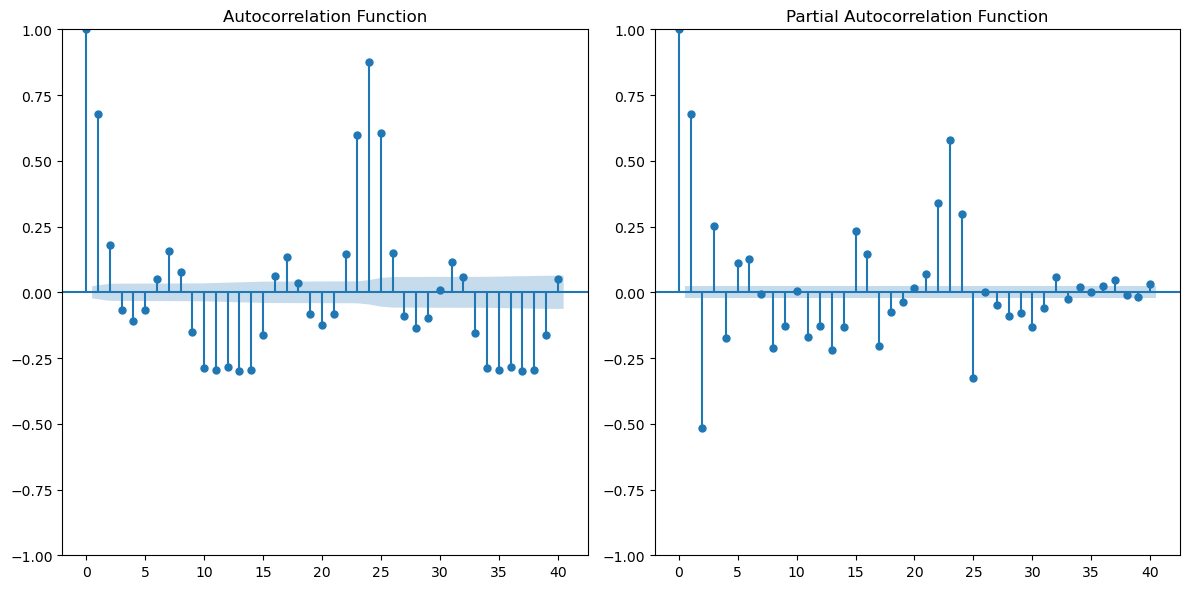

In [375]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Assuming 'eda_train' is the dataframe containing the 'orders' time series for the training data

# ACF and PACF analysis
plt.figure(figsize=(12, 6))

plt.subplot(121)
plot_acf(eda_train['orders'], ax=plt.gca(), lags=40)
plt.title('Autocorrelation Function')

plt.subplot(122)
plot_pacf(eda_train['orders'], ax=plt.gca(), lags=40)
plt.title('Partial Autocorrelation Function')

plt.tight_layout()
plt.show()


***ACF (Autocorrelation Function) Interpretation:***
Lag 1: There is a high positive autocorrelation at lag 1. This indicates that the current value of orders is positively correlated with the previous hour's orders.
Lag 24: There is another significant spike around lag 24, suggesting a strong daily seasonality in the data. This means the order patterns repeat approximately every 24 hours.

***PACF (Partial Autocorrelation Function) Interpretation:***
Lag 1: There is a significant positive spike at lag 1, indicating that the most recent hour's orders strongly influence the current hour's orders.
Lag 24: Another significant spike at lag 24, which indicates that after accounting for the intermediate lags.
Further lags: After lag 24, the partial autocorrelation values drop off more quickly compared to the ACF.

- Trend: There is no clear long-term upward or downward trend in the data, indicating stable demand over the period.
- Seasonality: The daily seasonality is evident from the significant spikes at multiples of 24 lags in both ACF and PACF plots. This suggests that the number of orders tends to follow a daily cycle.
- Stationarity: The slow decay in ACF and significant spikes in PACF at regular intervals suggest non-stationarity, likely due to the seasonality in the data. Differencing or seasonal decomposition might be necessary to achieve stationarity.

For our further analysis we will perform seasonal decomposition, trend, and stationarity analysis.

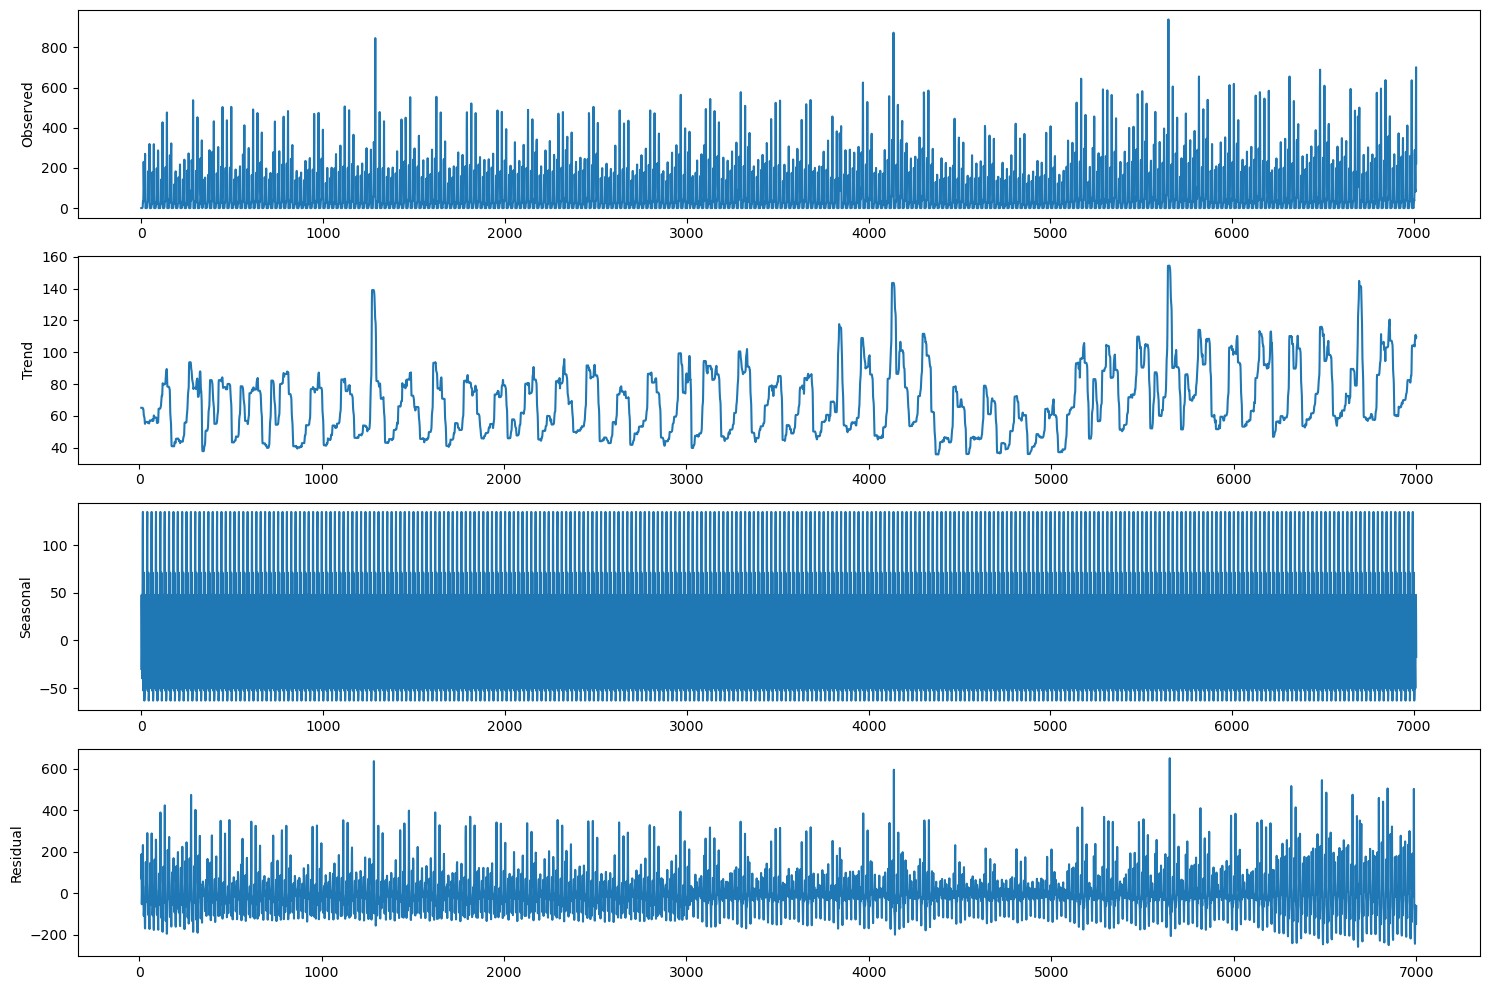

In [376]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Seasonal decomposition
decomposition = seasonal_decompose(eda_train['orders'], model='additive', period=24)

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15, 10))

decomposition.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')

decomposition.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')

decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')

decomposition.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')

plt.tight_layout()
plt.show()

1. **Observed**: The observed data displays variations in the number of orders over time, with noticeable fluctuations that suggest potential seasonal patterns and some peaks at certain intervals.
2. **Trend**: The trend line shows a general pattern in the number of orders. It appears that there are periods of higher and lower order volumes, indicating some cyclical behavior over longer periods. For instance, there are noticeable peaks that repeat approximately every few months.
3. **Seasonal**: The seasonal component indicates a strong daily seasonality, as shown by the repeating pattern.
4. **Residual**: The residuals appear to fluctuate around zero, with some noticeable spikes. These spikes could indicate outliers or unexpected variations in the data that are not explained by the trend or seasonality.

In [377]:
from statsmodels.tsa.stattools import adfuller

# Augmented Dickey-Fuller test
adf_result = adfuller(eda_train['orders'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

for key, value in adf_result[4].items():
    print(f'Critical Value {key}: {value}')


ADF Statistic: -11.269823575206319
p-value: 1.5467701312944866e-20
Critical Value 1%: -3.431287207235164
Critical Value 5%: -2.8619541701163453
Critical Value 10%: -2.566990458801652


In time series forecasting, especially for a food delivery app, stationarity is crucial. A stationary time series has properties (mean, variance, autocorrelation, etc.) that do not change over time, making it predictable and manageable. Stationary series are easier to model and provide more reliable forecasts. The ADF Statistic (-11.27) is much lower than all the critical values at the 1%, 5%, and 10% levels. This comparison confirms the stationarity of the time series

Weekly and Monthly Aggregation

In [378]:
# Weekly and Monthly Aggregation
eda_train.set_index('time', inplace=True)

# Resample and aggregate
weekly_df = eda_train.resample('W').agg({
    'orders': 'sum'
})
monthly_df = eda_train.resample('M').agg({
    'orders': 'sum'
})

# Feature Engineering: Calculate EMA for Weekly and Monthly Orders
span = 4

# Calculate EMA for Weekly Orders
weekly_df['EMA_Weekly_Orders'] = weekly_df['orders'].ewm(span=span, adjust=False).mean()

# Calculate EMA for Monthly Orders
monthly_df['EMA_Monthly_Orders'] = monthly_df['orders'].ewm(span=span, adjust=False).mean()

# Print results to verify
print("Weekly EMA Orders:")
print(weekly_df.head())

print("\nMonthly EMA Orders:")
print(monthly_df.head())


Weekly EMA Orders:
            orders  EMA_Weekly_Orders
time                                 
2021-02-07   11042          11042.000
2021-02-14   10307          10748.000
2021-02-21   11199          10928.400
2021-02-28   10854          10898.640
2021-03-07   11022          10947.984

Monthly EMA Orders:
            orders  EMA_Monthly_Orders
time                                  
2021-02-28   43402            43402.00
2021-03-31   46257            44544.00
2021-04-30   45774            45036.00
2021-05-31   47955            46203.60
2021-06-30   47739            46817.76


Stationarity Check, Differencing, and Plotting for Weekly Data

In [379]:
from statsmodels.tsa.stattools import adfuller

# Function to check stationarity for a list of columns
def check_stationarity(df, columns):
    non_stationary_series = []
    for column in columns:
        result = adfuller(df[column].dropna())
        p_value = result[1]  # p-value is at index 1 of the result
        if p_value >= 0.05:
            non_stationary_series.append(column)
    return non_stationary_series

# Check stationarity for weekly data columns
weekly_columns = ['EMA_Weekly_Orders']
non_stationary_results = check_stationarity(weekly_df, weekly_columns)

# Output the initial stationarity results
if non_stationary_results:
    print("Non-stationary series:")
    for series in non_stationary_results:
        print(series)
else:
    print("All series are stationary.")


Non-stationary series:
EMA_Weekly_Orders


In [380]:
# Function to apply differencing to make the series stationary
def apply_diff_and_update(df, column_name):
    diff_column_name = column_name + '_diff'
    df[diff_column_name] = df[column_name].diff()
    df.dropna(subset=[diff_column_name], inplace=True)
    return diff_column_name

# Apply differencing to non-stationary series
diff_columns = []
for column in non_stationary_results:
    diff_column = apply_diff_and_update(weekly_df, column)
    diff_columns.append(diff_column)

# Output the differenced columns to verify
print("Differenced columns:")
print(diff_columns)
print(weekly_df.head())


Differenced columns:
['EMA_Weekly_Orders_diff']
            orders  EMA_Weekly_Orders  EMA_Weekly_Orders_diff
time                                                         
2021-02-14   10307         10748.0000               -294.0000
2021-02-21   11199         10928.4000                180.4000
2021-02-28   10854         10898.6400                -29.7600
2021-03-07   11022         10947.9840                 49.3440
2021-03-14    9820         10496.7904               -451.1936


In [381]:
# Check stationarity again after differencing
non_stationary_results_after_diff = check_stationarity(weekly_df, diff_columns)

# Output the results after differencing
if non_stationary_results_after_diff:
    print("Non-stationary series after first differencing:")
    for series in non_stationary_results_after_diff:
        print(series)
else:
    print("All series are stationary after first differencing.")


All series are stationary after first differencing.


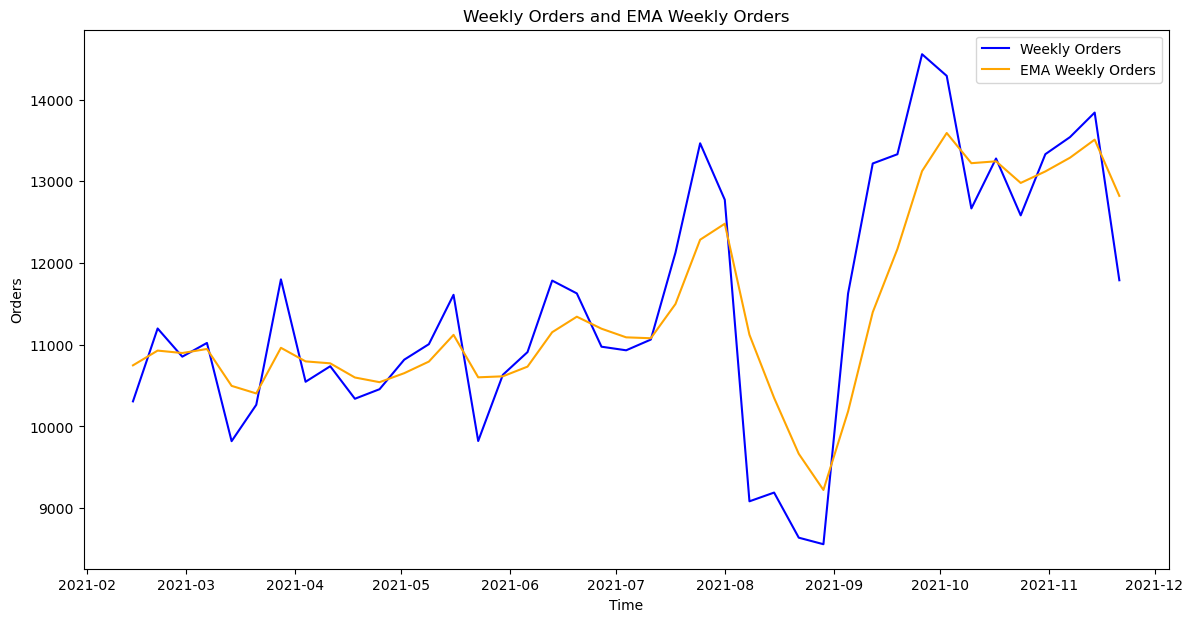

In [382]:
# Plot Weekly Orders and EMA Weekly Orders
plt.figure(figsize=(14, 7))
plt.plot(weekly_df.index, weekly_df['orders'], label='Weekly Orders', color='blue')
plt.plot(weekly_df.index, weekly_df['EMA_Weekly_Orders'], label='EMA Weekly Orders', color='orange')
plt.xlabel('Time')
plt.ylabel('Orders')
plt.title('Weekly Orders and EMA Weekly Orders')
plt.legend()
plt.show()


Stationarity Check, Differencing, and Plotting for Monthly Data

In [383]:
# Check stationarity for monthly data columns
monthly_columns = ['EMA_Monthly_Orders']
non_stationary_results_monthly = check_stationarity(monthly_df, monthly_columns)

# Output the initial stationarity results
if non_stationary_results_monthly:
    print("Non-stationary series:")
    for series in non_stationary_results_monthly:
        print(series)
else:
    print("All series are stationary.")

# Apply differencing to non-stationary series
diff_columns_monthly = []
for column in non_stationary_results_monthly:
    diff_column = apply_diff_and_update(monthly_df, column)
    diff_columns_monthly.append(diff_column)

# Check stationarity again after differencing
non_stationary_results_after_diff_monthly = check_stationarity(monthly_df, diff_columns_monthly)

# Output the results after differencing
if non_stationary_results_after_diff_monthly:
    print("Non-stationary series after differencing:")
    for series in non_stationary_results_after_diff_monthly:
        print(series)
else:
    print("All series are stationary after differencing.")

Non-stationary series:
EMA_Monthly_Orders
All series are stationary after differencing.


In [384]:
# If there are still non-stationary series after first differencing, apply second differencing
if non_stationary_results_after_diff_monthly:
    second_diff_columns_monthly = []
    for column in non_stationary_results_after_diff_monthly:
        second_diff_column = apply_diff_and_update(monthly_df, column)
        second_diff_columns_monthly.append(second_diff_column)

    # Check stationarity again after second differencing
    non_stationary_results_after_second_diff_monthly = check_stationarity(monthly_df, second_diff_columns_monthly)

    # Output the results after second differencing
    if non_stationary_results_after_second_diff_monthly:
        print("Non-stationary series after second differencing:")
        for series in non_stationary_results_after_second_diff_monthly:
            print(series)
    else:
        print("All series are stationary after second differencing.")



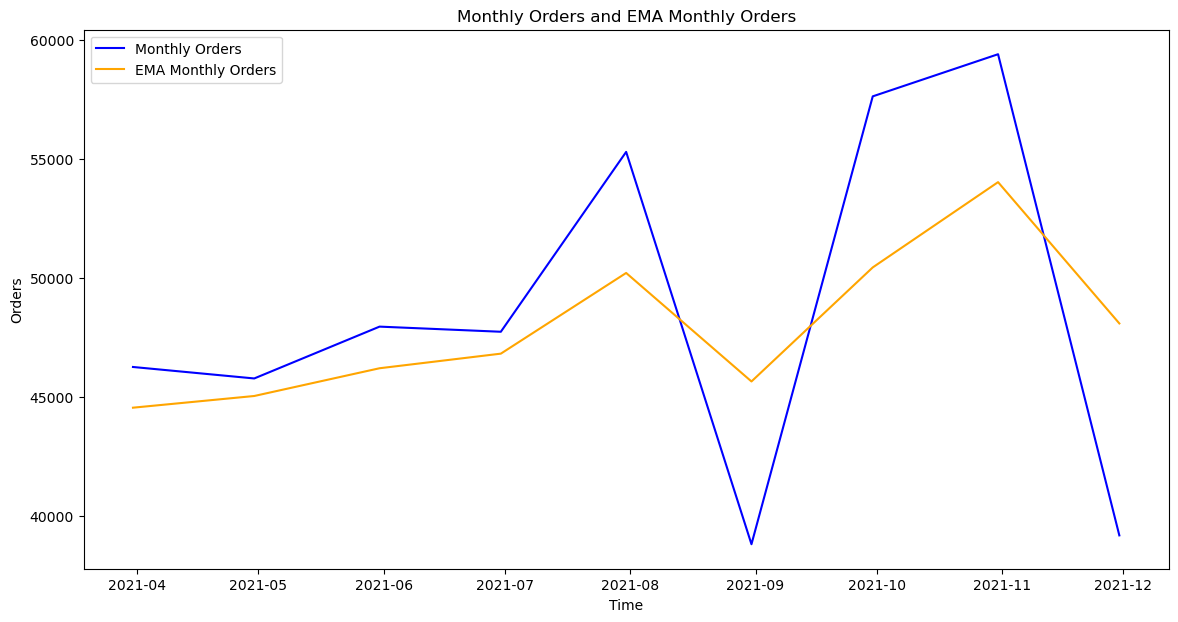

In [385]:
# Plot Weekly Orders and EMA Weekly Orders
plt.figure(figsize=(14, 7))
plt.plot(monthly_df.index, monthly_df['orders'], label='Monthly Orders', color='blue')
plt.plot(monthly_df.index, monthly_df['EMA_Monthly_Orders'], label='EMA Monthly Orders', color='orange')
plt.xlabel('Time')
plt.ylabel('Orders')
plt.title('Monthly Orders and EMA Monthly Orders')
plt.legend()
plt.show()

In [386]:
eda_train.head(5)

,city,orders,day_of_week,month,season,year,month_name,shift_time,meal_time,is_holiday
time,,,,,,,,,,
2021-02-01 00:00:00,BCN,0,Monday,2,Winter,2021,February,Night Shift,Late-Night,0
2021-02-01 01:00:00,BCN,0,Monday,2,Winter,2021,February,Night Shift,Late-Night,0
2021-02-01 02:00:00,BCN,0,Monday,2,Winter,2021,February,Night Shift,Late-Night,0
2021-02-01 03:00:00,BCN,0,Monday,2,Winter,2021,February,Night Shift,Late-Night,0
2021-02-01 04:00:00,BCN,0,Monday,2,Winter,2021,February,Night Shift,Late-Night,0


In [387]:
eda_test.head(5)

,time,city,orders,day_of_week,month,season,year,month_name,shift_time,meal_time,is_holiday
7013,2021-11-20 23:00:00,BCN,0,Saturday,11,Autumn,2021,November,Night Shift,Dinner,0
7014,2021-11-21 00:00:00,BCN,0,Sunday,11,Autumn,2021,November,Night Shift,Late-Night,0
7015,2021-11-21 01:00:00,BCN,0,Sunday,11,Autumn,2021,November,Night Shift,Late-Night,0
7016,2021-11-21 02:00:00,BCN,0,Sunday,11,Autumn,2021,November,Night Shift,Late-Night,0
7017,2021-11-21 03:00:00,BCN,0,Sunday,11,Autumn,2021,November,Night Shift,Late-Night,0



## Modelling

Try different models. Validate each model in a way that would imitate the real problem (every sunday you forecast all of next week). Watch out for data leakage. Evaluate each model on MSE and SMAPE. Which one performs better?


### 1) Random Forest

In [388]:
eda_train

,city,orders,day_of_week,month,season,year,month_name,shift_time,meal_time,is_holiday
time,,,,,,,,,,
2021-02-01 00:00:00,BCN,0,Monday,2,Winter,2021,February,Night Shift,Late-Night,0
2021-02-01 01:00:00,BCN,0,Monday,2,Winter,2021,February,Night Shift,Late-Night,0
2021-02-01 02:00:00,BCN,0,Monday,2,Winter,2021,February,Night Shift,Late-Night,0
2021-02-01 03:00:00,BCN,0,Monday,2,Winter,2021,February,Night Shift,Late-Night,0
2021-02-01 04:00:00,BCN,0,Monday,2,Winter,2021,February,Night Shift,Late-Night,0
...,...,...,...,...,...,...,...,...,...,...
2021-11-20 18:00:00,BCN,82,Saturday,11,Autumn,2021,November,Evening Shift,Dinner,0
2021-11-20 19:00:00,BCN,135,Saturday,11,Autumn,2021,November,Evening Shift,Dinner,0
2021-11-20 20:00:00,BCN,401,Saturday,11,Autumn,2021,November,Night Shift,Dinner,0


In [389]:
eda_test

,time,city,orders,day_of_week,month,season,year,month_name,shift_time,meal_time,is_holiday
7013,2021-11-20 23:00:00,BCN,0,Saturday,11,Autumn,2021,November,Night Shift,Dinner,0
7014,2021-11-21 00:00:00,BCN,0,Sunday,11,Autumn,2021,November,Night Shift,Late-Night,0
7015,2021-11-21 01:00:00,BCN,0,Sunday,11,Autumn,2021,November,Night Shift,Late-Night,0
7016,2021-11-21 02:00:00,BCN,0,Sunday,11,Autumn,2021,November,Night Shift,Late-Night,0
7017,2021-11-21 03:00:00,BCN,0,Sunday,11,Autumn,2021,November,Night Shift,Late-Night,0
...,...,...,...,...,...,...,...,...,...,...,...
8761,2022-02-01 19:00:00,BCN,101,Tuesday,2,Winter,2022,February,Evening Shift,Dinner,0
8762,2022-02-01 20:00:00,BCN,266,Tuesday,2,Winter,2022,February,Night Shift,Dinner,0
8763,2022-02-01 21:00:00,BCN,298,Tuesday,2,Winter,2022,February,Night Shift,Dinner,0
8764,2022-02-01 22:00:00,BCN,128,Tuesday,2,Winter,2022,February,Night Shift,Dinner,0


In [394]:
# Drop unnecessary columns and prepare data for modeling
columns_to_drop = ['city', 'month_name']  # Adjust if there are more columns to drop
rf_train = eda_train.drop(columns_to_drop, axis=1, errors='ignore')
rf_test = eda_test.drop(columns_to_drop, axis=1, errors='ignore')

# Define the target and features
y_train = rf_train.pop('orders')
y_test = rf_test.pop('orders')

# Encoding categorical variables
categorical_features = ['day_of_week', 'season', 'meal_time', 'shift_time']
non_categorical_features = ['is_holiday']  # 'is_holiday' is already binary and does not need encoding
onehot_encoder = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features)
    ],
    remainder='passthrough'
)

# Apply one-hot encoding to both training and testing data
X_train_encoded = onehot_encoder.fit_transform(rf_train)
X_test_encoded = onehot_encoder.transform(rf_test)

# Define the Random Forest model with the optimal parameters
rf_optimal = RandomForestRegressor(
    n_estimators=100,
    max_features='sqrt',
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=4,
    random_state=42
)

# Train the model
rf_optimal.fit(X_train_encoded, y_train)
predictions = rf_optimal.predict(X_test_encoded)

# Calculate and print evaluation metrics
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, predictions)
print(f"Random Forest - MSE: {mse}, RMSE: {rmse}, MAE: {mae}")

Random Forest - MSE: 8398.740386153468, RMSE: 91.64464188458301, MAE: 45.920956182723636


In [ ]:
# Define the Random Forest model
rf = RandomForestRegressor(random_state=42)

# Create a dictionary of all values we want to test in the grid search
param_grid = {
    'n_estimators': [100, 200, 300],       # Number of trees in the random forest
    'max_features': ['sqrt'],              # Number of features to consider at every split (use 'sqrt')
    'max_depth': [None, 10, 20, 30],       # Maximum number of levels in tree
    'min_samples_split': [2, 5, 10],       # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]          # Minimum number of samples required at each leaf node
}

# Define the scoring metric using mean squared error
mse = make_scorer(mean_squared_error, greater_is_better=False)

# Setup the grid search with 3-fold cross-validation
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring=mse, verbose=2, n_jobs=-1)

# Assuming X_train_encoded and y_train are already defined and prepared
grid_rf.fit(X_train_encoded, y_train)

# Best model's parameters
print("Best parameters:", grid_rf.best_params_)

# Best model's performance (negative MSE is converted to positive by multiplying by -1)
print("Best score (MSE):", -grid_rf.best_score_)


Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best score (MSE): 4585.428917772609


Random Forest has best overall performance, this suggests that the time series has strong non-linear components

In [399]:
# Feature importances
importances = rf_optimal.feature_importances_
feature_names = onehot_encoder.get_feature_names_out()

# Create a dataframe for visualization
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)


feature_importance_df.head(10)


,feature,importance
12,cat__meal_time_Dinner,0.230906
13,cat__meal_time_Late-Night,0.181980
11,cat__meal_time_Breakfast,0.111181
16,cat__shift_time_Evening Shift,0.089757
18,cat__shift_time_Night Shift,0.085173
17,cat__shift_time_Mid Shift,0.067214
14,cat__meal_time_Lunch,0.055078
15,cat__shift_time_Early Shift,0.052005
0,cat__day_of_week_Friday,0.028143
19,remainder__month,0.026226


In [398]:
# Plot feature importances using Plotly
fig = px.bar(feature_importance_df, x='importance', y='feature', orientation='h', title='Feature Importances')
fig.show()

In [400]:
"""
feature_importances = rf.feature_importances_
features = rf_train.columns
feature_importance_dict = dict(zip(features, feature_importances))
for feature, importance in sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True):
    print(f"{feature}: {importance}")
"""

'\nfeature_importances = rf.feature_importances_\nfeatures = rf_train.columns\nfeature_importance_dict = dict(zip(features, feature_importances))\nfor feature, importance in sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True):\n    print(f"{feature}: {importance}")\n'

In [ ]:
import plotly.express as px

# Calculate residuals
residuals = y_test - predictions

# Create a residual plot
fig = px.scatter(x=predictions, y=residuals, labels={'x':'Predictions', 'y':'Residuals'}, title='Residual Plot')
fig.add_hline(y=0, line_dash="dash")
fig.show()


In [401]:

# Define the model
rf = RandomForestRegressor(random_state=42)

# Create a dictionary of all values we want to test
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the random forest
    'max_features': ['auto', 'sqrt'],  # Number of features to consider at every split
    'max_depth': [None, 10, 20, 30],  # Maximum number of levels in tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]     # Minimum number of samples required at each leaf node
}

# Use the mean squared error to measure performance
mse = make_scorer(mean_squared_error, greater_is_better=False)

# Setup the grid search
grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring=mse, verbose=2, n_jobs=-1)

# Assuming X_train_encoded and y_train are already defined and prepared
grid_rf.fit(X_train_encoded, y_train)

# Best model's parameters
print("Best parameters:", grid_rf.best_params_)
# Best model's performance
print("Best score (MSE):", -grid_rf.best_score_)



Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
Best score (MSE): 4585.428917772609


### 2. Autoregressive Integrated Moving Average (ARIMA) & Seasonal ARIMA (SARIMA)

In [266]:
eda_train.head()

,city,orders,day_of_week,month,season,year,month_name,shift_time,meal_time,is_holiday
time,,,,,,,,,,
2021-02-01 00:00:00,BCN,0,Monday,2,Winter,2021,February,Night Shift,Late-Night,0
2021-02-01 01:00:00,BCN,0,Monday,2,Winter,2021,February,Night Shift,Late-Night,0
2021-02-01 02:00:00,BCN,0,Monday,2,Winter,2021,February,Night Shift,Late-Night,0
2021-02-01 03:00:00,BCN,0,Monday,2,Winter,2021,February,Night Shift,Late-Night,0
2021-02-01 04:00:00,BCN,0,Monday,2,Winter,2021,February,Night Shift,Late-Night,0


In [273]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import itertools
import numpy as np
import warnings
import sys
import os
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Suppress error messages
class SuppressOutput:
    def __enter__(self):
        self._stderr = sys.stderr
        sys.stderr = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_value, traceback):
        sys.stderr.close()
        sys.stderr = self._stderr

# Assuming 'eda_train' and 'eda_test' are your datasets
eda_train['time'] = pd.to_datetime(eda_train.index)
eda_test['time'] = pd.to_datetime(eda_test.index)

eda_train.set_index('time', inplace=True)
eda_test.set_index('time', inplace=True)

# Aggregating data weekly and monthly
weekly_train = eda_train.resample('W').agg({'orders': 'sum'})
monthly_train = eda_train.resample('M').agg({'orders': 'sum'})

weekly_test = eda_test.resample('W').agg({'orders': 'sum'})
monthly_test = eda_test.resample('M').agg({'orders': 'sum'})

# Calculate EMA
span = 4
weekly_train['EMA_Weekly_Orders'] = weekly_train['orders'].ewm(span=span, adjust=False).mean()
monthly_train['EMA_Monthly_Orders'] = monthly_train['orders'].ewm(span=span, adjust=False).mean()

# Ensure stationary by differencing if necessary (although ADF suggests it's not needed)
weekly_train['orders_diff'] = weekly_train['orders'].diff().dropna()
monthly_train['orders_diff'] = monthly_train['orders'].diff().dropna()

# Use differenced data if necessary
y_train_weekly = weekly_train['orders_diff'].dropna()
y_test_weekly = weekly_test['orders'].diff().dropna()

y_train_monthly = monthly_train['orders_diff'].dropna()
y_test_monthly = monthly_test['orders'].diff().dropna()

# Ensure there are enough observations after differencing
if len(y_train_weekly) < 2 * 12:  # Adjust the factor based on your seasonal period
    raise ValueError("Not enough data points after differencing for SARIMA modeling.")

# Define parameter grid for grid search
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Grid search for SARIMA (using weekly data for this example)
best_mse = np.inf
best_order = None
best_seasonal_order = None
best_sarima_model = None

with SuppressOutput():
    for param in pdq:
        for seasonal_param in seasonal_pdq:
            try:
                model = SARIMAX(y_train_weekly, order=param, seasonal_order=seasonal_param,
                                enforce_stationarity=False, enforce_invertibility=False)
                results = model.fit(disp=False, maxiter=200)
                forecast = results.get_forecast(steps=len(y_test_weekly))
                mse = mean_squared_error(y_test_weekly, forecast.predicted_mean)
                if mse < best_mse:
                    best_mse = mse
                    best_order = param
                    best_seasonal_order = seasonal_param
                    best_sarima_model = results
            except Exception as e:
                # Print the error if necessary
                # print(f"Error for SARIMA parameters {param}x{seasonal_param}: {e}")
                continue

if best_sarima_model:
    print(f'Best SARIMA Order: {best_order} - Seasonal Order: {best_seasonal_order} - MSE: {best_mse}')
    # Forecast using the best SARIMA model
    sarima_forecast = best_sarima_model.get_forecast(steps=len(y_test_weekly)).predicted_mean

    # Calculate and print errors
    mse = mean_squared_error(y_test_weekly, sarima_forecast)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_weekly, sarima_forecast)
    print(f'SARIMA - MSE: {mse}, RMSE: {rmse}, MAE: {mae}')
else:
    print("No suitable SARIMA model found.")


No suitable SARIMA model found.


In [268]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import itertools
import numpy as np

# Assuming 'eda_train' and 'eda_test' are your datasets
eda_train['time'] = pd.to_datetime(eda_train.index)
eda_test['time'] = pd.to_datetime(eda_test.index)

eda_train.set_index('time', inplace=True)
eda_test.set_index('time', inplace=True)

# Aggregating data weekly and monthly
weekly_train = eda_train.resample('W').agg({'orders': 'sum'})
monthly_train = eda_train.resample('M').agg({'orders': 'sum'})

weekly_test = eda_test.resample('W').agg({'orders': 'sum'})
monthly_test = eda_test.resample('M').agg({'orders': 'sum'})

# Calculate EMA
span = 4
weekly_train['EMA_Weekly_Orders'] = weekly_train['orders'].ewm(span=span, adjust=False).mean()
monthly_train['EMA_Monthly_Orders'] = monthly_train['orders'].ewm(span=span, adjust=False).mean()

# Ensure stationary by differencing if necessary (although ADF suggests it's not needed)
weekly_train['orders_diff'] = weekly_train['orders'].diff().dropna()
monthly_train['orders_diff'] = monthly_train['orders'].diff().dropna()

# Use differenced data if necessary
y_train_weekly = weekly_train['orders_diff'].dropna()
y_test_weekly = weekly_test['orders'].diff().dropna()

y_train_monthly = monthly_train['orders_diff'].dropna()
y_test_monthly = monthly_test['orders'].diff().dropna()

# Define parameter grid for grid search
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Grid search for SARIMA (using weekly data for this example)
best_mse = np.inf
best_order = None
best_seasonal_order = None
best_sarima_model = None

for param in pdq:
    for seasonal_param in seasonal_pdq:
        try:
            model = SARIMAX(y_train_weekly, order=param, seasonal_order=seasonal_param)
            results = model.fit(disp=False)
            forecast = results.forecast(steps=len(y_test_weekly))
            mse = mean_squared_error(y_test_weekly, forecast)
            if mse < best_mse:
                best_mse = mse
                best_order = param
                best_seasonal_order = seasonal_param
                best_sarima_model = results
        except:
            continue

print(f'Best SARIMA Order: {best_order} - Seasonal Order: {best_seasonal_order} - MSE: {best_mse}')

# Forecast using the best SARIMA model
sarima_forecast = best_sarima_model.forecast(steps=len(y_test_weekly))

# Calculate and print errors
mse = mean_squared_error(y_test_weekly, sarima_forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_weekly, sarima_forecast)
print(f'SARIMA - MSE: {mse}, RMSE: {rmse}, MAE: {mae}')


c:\Users\monbi\Anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

c:\Users\monbi\Anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

c:\Users\monbi\Anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

c:\Users\monbi\Anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

c:\Users\monbi\Anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimiz

Best SARIMA Order: None - Seasonal Order: None - MSE: inf


AttributeError: 'NoneType' object has no attribute 'forecast'

In [267]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming 'eda_train' and 'eda_test' are your datasets with 'time', 'orders', etc.
# First, ensure that 'time' is a datetime column and set it as index if not already
eda_train['time'] = pd.to_datetime(eda_train.index)
eda_test['time'] = pd.to_datetime(eda_test.index)

eda_train.set_index('time', inplace=True)
eda_test.set_index('time', inplace=True)

# Split the data into features and target explicitly if not done
y_train = eda_train['orders']
y_test = eda_test['orders']

# ARIMA Model
arima_model = ARIMA(y_train, order=(1,1,1))
arima_fitted = arima_model.fit()
arima_forecast = arima_fitted.forecast(steps=len(y_test))

# SARIMA Model
sarima_model = SARIMAX(y_train, order=(1,1,1), seasonal_order=(1,1,1,24))
sarima_fitted = sarima_model.fit()
sarima_forecast = sarima_fitted.forecast(steps=len(y_test))

# Calculate and print errors
for forecast, model_name in [(arima_forecast, 'SARIMA'), (sarima_forecast, 'ARIMA')]:
    mse = mean_squared_error(y_test, forecast)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, forecast)
    print(f'{model_name} - MSE: {mse}, RMSE: {rmse}, MAE: {mae}')


c:\Users\monbi\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\monbi\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\monbi\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

c:\Users\monbi\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\monbi\Anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is ava

SARIMA - MSE: 36518.113184720576, RMSE: 191.09713023674786, MAE: 135.46007947259415
ARIMA - MSE: 2808.58828279943, RMSE: 52.99611573313114, MAE: 27.02334104266949
